In [ ]:
import os
import glob
import json
import math
import shutil
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

from google.colab import drive

# 0. Setup and Configuration

In [14]:
# Mount Drive (Colab)
drive.mount('/content/drive')

# Paths
SAVE_PATH = "/content/drive/My Drive/NLP_Project_Results/"
MAIN_CSV_PATH = "master_results_log_intermediate_most_recent.csv"

print("=== 0. Setup ===")
print(f"- Results path: {SAVE_PATH}")
print(f"- Main CSV file: {MAIN_CSV_PATH}")

# Plot style
sns.set_theme(style="whitegrid", context="talk")
PALETTE = sns.color_palette("Set2", n_colors=12)
sns.set_palette(PALETTE)
plt.rcParams["figure.figsize"] = (10, 6)

# Clear cache (avoid memory issues on Colab)
shutil.rmtree('/root/.cache', ignore_errors=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== 0. Setup ===
- Results path: /content/drive/My Drive/NLP_Project_Results/
- Main CSV file: master_results_log_intermediate_most_recent.csv


# 1. Data Loading Utilities

In [ ]:


def load_main_results(csv_path: str) -> pd.DataFrame:
    """
    Load and clean the main results CSV:
    - Drop rows with NaN accuracy.
    - Remove failed runs where epoch == -1.
    """
    df = pd.read_csv(csv_path)
    if "metrics.accuracy" in df.columns:
        df = df.dropna(subset=["metrics.accuracy"])
    if "epoch" in df.columns:
        df = df[df["epoch"] != -1]
    return df


def get_final_epoch_df(df_main: pd.DataFrame) -> pd.DataFrame:
    """
    Return only the final epoch row for each experiment (exp_id).
    """
    final_idx = df_main.groupby("exp_id")["epoch"].idxmax()
    df_final = df_main.loc[final_idx].copy()
    return df_final


def load_grad_logs(save_path: str, df_main: pd.DataFrame) -> pd.DataFrame | None:
    """
    Parse all grad_log_*.json files and merge them with main configs.
    Returns df_analysis (per-step log + config), or None if no logs.
    """
    json_files = glob.glob(os.path.join(save_path, "grad_log_*.json"))
    if not json_files:
        print(f"No grad_log_*.json files found in {save_path}.")
        return None

    print(f"Found {len(json_files)} gradient log files.")
    all_log_data = []

    for file_path in json_files:
        filename = os.path.basename(file_path)
        try:
            # 'grad_log_0006_some_name.json' -> '0006'
            exp_id = filename.split('_')[2]

            with open(file_path, "r") as f:
                log_data = json.load(f)

            for step_data in log_data:
                step = step_data["step"]
                params = step_data["current_trainable_params"]

                # One row for the total params at this step
                all_log_data.append(
                    {
                        "exp_id": exp_id,
                        "step": step,
                        "layer": "all_params",
                        "action": "all",
                        "trainable_params": params,
                    }
                )

                # One row per layer
                for layer, data in step_data["layers"].items():
                    all_log_data.append(
                        {
                            "exp_id": exp_id,
                            "step": step,
                            "layer": layer,
                            "action": data["action"],
                            "trainable_params": params,
                        }
                    )
        except Exception as e:
            print(f"Warning: Skipping file {filename} due to parse error: {e}")

    if not all_log_data:
        print("No valid log entries found.")
        return None

    df_logs = pd.DataFrame(all_log_data)

    # Normalize exp_id for merge
    df_main = df_main.copy()
    df_main["exp_id"] = df_main["exp_id"].astype(str).str.zfill(4)
    df_logs["exp_id"] = df_logs["exp_id"].astype(str).str.zfill(4)

    config_cols = [
        "exp_id",
        "task",
        "model",
        "strategy",
        "lr",
        "lora_config.r",
        "dynamic_config.num_updates_per_epoch",
        "dynamic_config.threshold_percentile",
    ]
    existing_cols = [c for c in config_cols if c in df_main.columns]
    df_configs = df_main[existing_cols].drop_duplicates(subset=["exp_id"])

    df_analysis = pd.merge(df_logs, df_configs, on="exp_id", how="left")

    print("Gradient logs parsed and merged with config.")
    return df_analysis


def add_unified_metric_column(df: pd.DataFrame, metric_col: str = "metric") -> pd.DataFrame:
    """
    Add a unified metric column to df:
    - For MRPC: use F1 (metrics.f1 / metrics.f1_score / metrics.f1_macro).
    - Otherwise: use metrics.accuracy.
    """
    def _get_metric(row):
        if row["task"] == "mrpc":
            for key in ["metrics.f1", "metrics.f1_score", "metrics.f1_macro"]:
                if key in row and pd.notna(row[key]):
                    return row[key]
            return None
        return row["metrics.accuracy"]

    df = df.copy()
    df[metric_col] = df.apply(_get_metric, axis=1)
    return df



# 2. Load Main Results and Gradient Logs

In [16]:

print("\n=== 2. Loading data ===")
try:
    # Main results (all epochs)
    df_main_cleaned = load_main_results(MAIN_CSV_PATH)
    print(f"- Cleaned rows in main CSV: {len(df_main_cleaned)}")

    # Final-epoch-only view
    df_final = get_final_epoch_df(df_main_cleaned)
    print(f"- Final-epoch experiments: {len(df_final)}")

    # Gradient logs + merged config
    df_analysis = load_grad_logs(SAVE_PATH, df_main_cleaned)

except Exception as e:
    df_main_cleaned, df_final, df_analysis = None, None, None
    print(f"Error during data loading: {e}")




=== 2. Loading data ===
- Cleaned rows in main CSV: 6012
- Final-epoch experiments: 1097
Found 731 gradient log files.
Gradient logs parsed and merged with config.


# 3. Strategy Filtering and Best-Run Selection (GLUE)

In [17]:

print("\n=== 3. Strategy filtering and best-run selection (GLUE) ===")

# 3.1 Filter strategies of interest
strategies_of_interest = [
    "dynamic_grad_norm",
    "topk_full",
    "bitfit",
]

df_sub = df_final[df_final["strategy"].isin(strategies_of_interest)].copy()

# 3.2 Unified metric column
df_sub = add_unified_metric_column(df_sub, metric_col="metric")

# 3.3 Restrict dynamic runs to u=6, t=10
df_sub["dynamic_config.num_updates_per_epoch"] = (
    df_sub["dynamic_config.num_updates_per_epoch"].astype(float).astype("Int64")
)
df_sub["dynamic_config.threshold_percentile"] = (
    df_sub["dynamic_config.threshold_percentile"].astype(float).astype("Int64")
)

df_sub = df_sub[
    ~(
        (df_sub["strategy"] == "dynamic_grad_norm") &
        ~(
            (df_sub["dynamic_config.num_updates_per_epoch"] == 6) &
            (df_sub["dynamic_config.threshold_percentile"] == 10)
        )
    )
]

# 3.4 Keep top-k parameter, ensure non-topk runs have "0"
df_sub["topk_layers.k"] = df_sub["topk_layers.k"].astype("Int64")
df_sub.loc[df_sub["strategy"] != "topk_full", "topk_layers.k"] = 0
df_sub["topk_layers.k"] = df_sub["topk_layers.k"].astype(str)

# 3.5 Pick best run per (model, task, strategy, k)
df_best = (
    df_sub.sort_values("metric", ascending=False)
    .groupby(["model", "task", "strategy", "topk_layers.k"])
    .head(1)
    .reset_index(drop=True)
)

df_best_small = df_best[
    [
        "model",
        "strategy",
        "topk_layers.k",
        "task",
        "metric",
        "training_time_seconds"
    ]
]

print(f"- Best rows selected: {len(df_best_small)}")



=== 3. Strategy filtering and best-run selection (GLUE) ===
- Best rows selected: 84


# 4. Plot: Dynamic vs Top-k (Accuracy/F1 and Training Time)


=== 4. Plotting: Dynamic vs Top-k (GLUE) ===


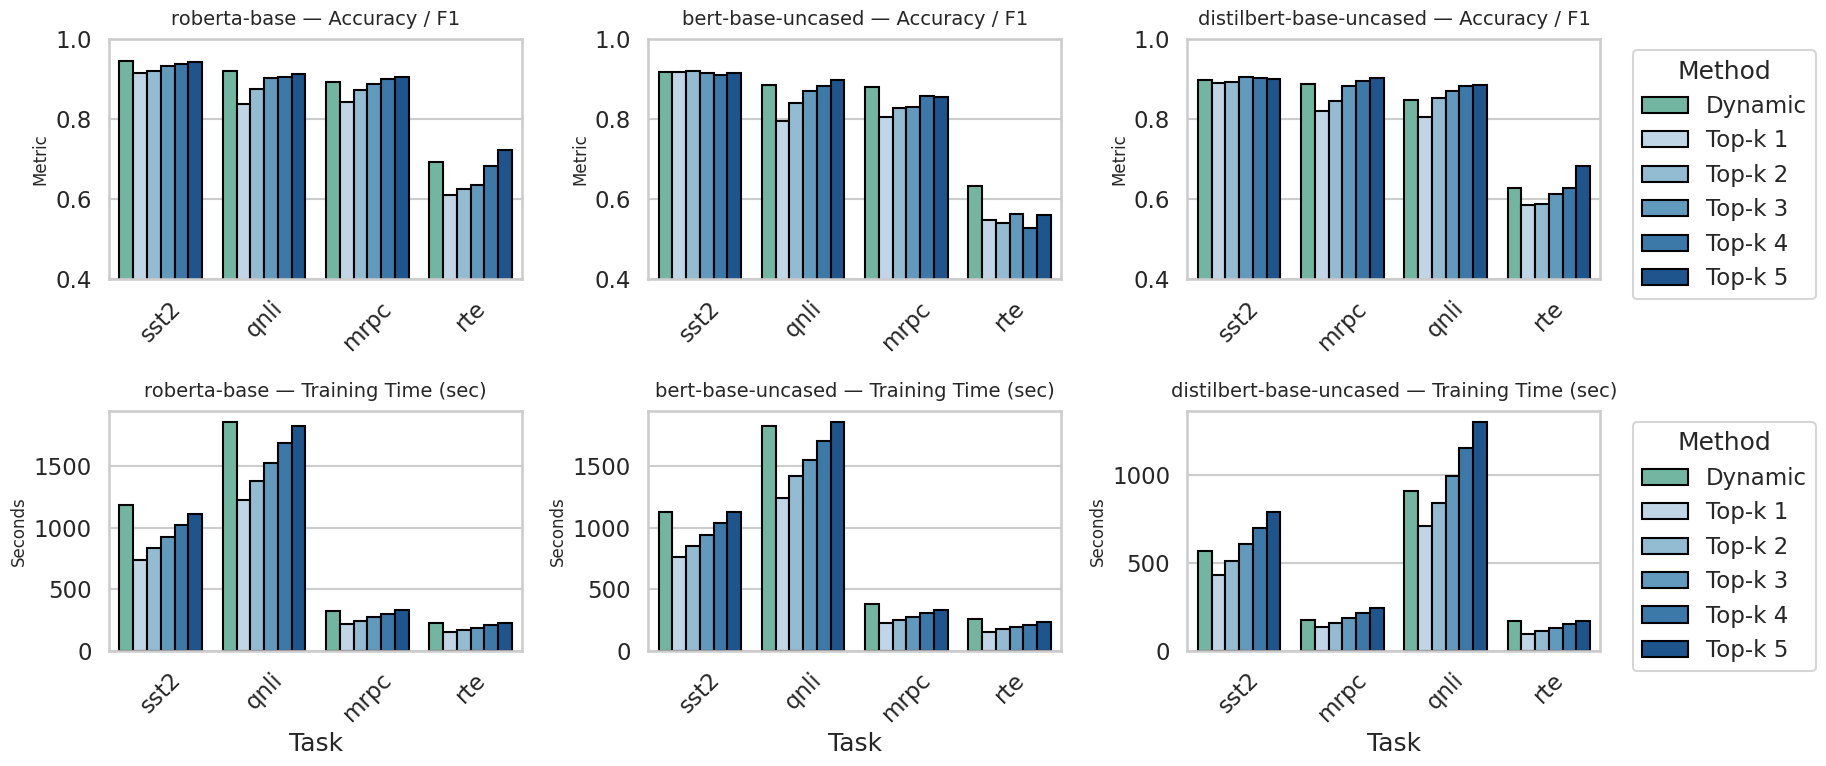

In [18]:

print("\n=== 4. Plotting: Dynamic vs Top-k (GLUE) ===")

df_plot = df_best_small[
    df_best_small["strategy"].isin(["dynamic_grad_norm", "topk_full"])
].copy()

# Rename methods (Dynamic vs Top-k k)
df_plot["method"] = df_plot.apply(
    lambda r: f"Top-k {r['topk_layers.k']}" if r["strategy"] == "topk_full" else "Dynamic",
    axis=1
)

# Method ordering
method_order = ["Dynamic"] + [f"Top-k {k}" for k in [1, 2, 3, 4, 5]]
df_plot["method"] = pd.Categorical(df_plot["method"], categories=method_order, ordered=True)

# Custom palette: Dynamic + gradient for Top-k
dynamic_color = sns.color_palette("Set2", 1)[0]
topk_shades = sns.color_palette("Blues", 6)[1:]
palette = {"Dynamic": dynamic_color}
for i, k in enumerate([1, 2, 3, 4, 5]):
    palette[f"Top-k {k}"] = topk_shades[i]

models = df_plot["model"].unique()
n_models = len(models)

fig, axes = plt.subplots(2, n_models, figsize=(6.2 * n_models, 8), sharey=False)

for idx, model in enumerate(models):
    df_m = df_plot[df_plot["model"] == model]

    # Accuracy / F1 plot
    ax = axes[0, idx]
    sns.barplot(
        data=df_m,
        x="task",
        y="metric",
        hue="method",
        palette=palette,
        edgecolor="black",
        ax=ax,
    )
    ax.set_ylim(0.4, 1.0)
    ax.set_title(f"{model} — Accuracy / F1", fontsize=14, pad=10)
    ax.set_xlabel("")
    ax.set_ylabel("Metric", fontsize=12)
    ax.tick_params(axis="x", rotation=45)

    if idx == n_models - 1:
        ax.legend(title="Method", bbox_to_anchor=(1.05, 1))
    else:
        ax.legend_.remove()

    # Training time plot
    ax2 = axes[1, idx]
    sns.barplot(
        data=df_m,
        x="task",
        y="training_time_seconds",
        hue="method",
        palette=palette,
        edgecolor="black",
        ax=ax2,
    )
    ax2.set_title(f"{model} — Training Time (sec)", fontsize=14, pad=10)
    ax2.set_xlabel("Task")
    ax2.set_ylabel("Seconds", fontsize=12)
    ax2.tick_params(axis="x", rotation=45)

    if idx == n_models - 1:
        ax2.legend(title="Method", bbox_to_anchor=(1.05, 1))
    else:
        ax2.legend_.remove()

plt.subplots_adjust(hspace=0.35, wspace=0.25)
plt.tight_layout()
plt.show()



# 5. Dynamic Pruning Behavior Across GLUE and gsm8k Tasks


=== Final 5-Panel Dynamic Pruning Figure ===


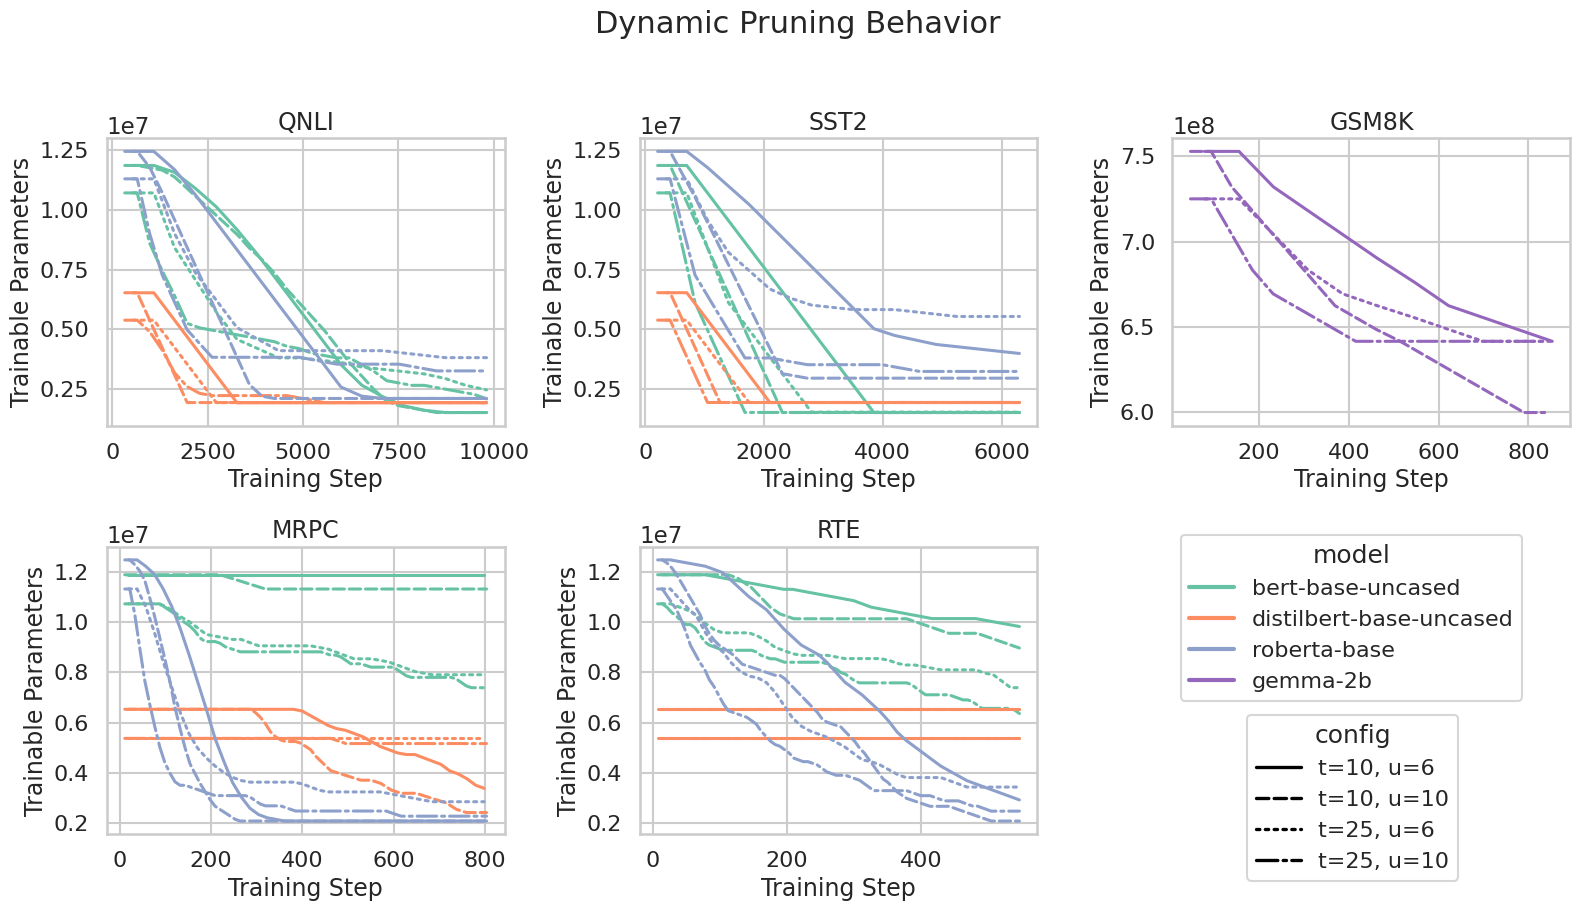

In [ ]:

print("\n=== Final 5-Panel Dynamic Pruning Figure ===")

# ---------- Prepare GLUE ----------
df_dyn = df_analysis[df_analysis["layer"] == "all_params"].copy()
df_dyn = df_dyn[df_dyn["dynamic_config.threshold_percentile"].isin([10, 25])]
df_dyn = df_dyn[df_dyn["dynamic_config.num_updates_per_epoch"].isin([6, 10])]

df_dyn_avg = (
    df_dyn.groupby([
        "task", "model",
        "dynamic_config.threshold_percentile",
        "dynamic_config.num_updates_per_epoch",
        "step",
    ])["trainable_params"]
    .mean()
    .reset_index()
)

df_dyn_avg["config"] = (
    "t=" + df_dyn_avg["dynamic_config.threshold_percentile"].astype(int).astype(str)
    + ", u=" + df_dyn_avg["dynamic_config.num_updates_per_epoch"].astype(int).astype(str)
)

# ---------- Prepare GSM8K ----------
csv_path_gsm = "gsm8k_new_most_recent.csv"
df_gsm = pd.read_csv(csv_path_gsm)
df_gsm = df_gsm[df_gsm["strategy"] == "dynamic_grad_norm"].copy()

logs_folder = "jsonsnew"
all_logs = []

for fname in os.listdir(logs_folder):
    if fname.endswith(".json"):
        run_id = fname.split("_")[-1].replace(".json", "")
        log_path = os.path.join(logs_folder, fname)
        with open(log_path, "r") as f:
            log_data = json.load(f)

        row = df_gsm[df_gsm["exp_id"] == run_id]
        if len(row) == 0:
            continue
        row = row.iloc[0]

        for entry in log_data:
            all_logs.append({
                "step": entry["step"],
                "trainable_params": entry["current_trainable_params"],
                "threshold": int(row["dynamic_threshold_percentile"]),
                "updates_per_epoch": int(row["dynamic_num_updates_per_epoch"]),
                "model": "gemma-2b",
            })

df_logs_gsm = pd.DataFrame(all_logs)

df_logs_gsm["config"] = (
    "t=" + df_logs_gsm["threshold"].astype(int).astype(str)
    + ", u=" + df_logs_gsm["updates_per_epoch"].astype(int).astype(str)
)

df_avg_gsm = (
    df_logs_gsm.groupby(["model", "config", "step"])["trainable_params"]
    .mean()
    .reset_index()
)

min_step = df_avg_gsm.groupby(["config"])["step"].max().min()
df_avg_gsm = df_avg_gsm[df_avg_gsm["step"] <= 870]
df_avg_gsm["task"] = "gsm8k"

# ---------- Combine ----------
df_combined = pd.concat([
    df_dyn_avg[["task", "model", "config", "step", "trainable_params"]],
    df_avg_gsm[["task", "model", "config", "step", "trainable_params"]],
])

# Final task order/layout
row_order = [["qnli", "sst2", "gsm8k"],
             ["mrpc", "rte"]]

# ---------- Colors & Styles ----------
palette_models = {
    "bert-base-uncased": "#66c2a5",
    "distilbert-base-uncased": "#fc8d62",
    "roberta-base": "#8da0cb",
    "gemma-2b": "#9467bd",  # purple
}

linestyles = {
    "t=10, u=6": "solid",
    "t=10, u=10": "dashed",
    "t=25, u=6": "dotted",
    "t=25, u=10": "dashdot",
}

# ---------- Plot (3×2) ----------
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 3, figsize=(16, 9), sharey=False)
axes[1, 2].axis('off')  # empty

for r in range(2):
    for c in range(3):
        if r == 1 and c == 2:
            continue

        task = row_order[r][c]
        ax = axes[r, c]
        df_t = df_combined[df_combined["task"] == task]

        for (model, config), sub in df_t.groupby(["model", "config"]):
            style = linestyles.get(config, "solid")  # safety
            ax.plot(
                sub["step"],
                sub["trainable_params"],
                color=palette_models.get(model, "black"),
                linestyle=style,
                linewidth=2.2,
                alpha=1.0,
                solid_capstyle="round",
                dash_capstyle="round",
            )

        ax.set_title(task.upper(), fontsize=17)
        ax.set_xlabel("Training Step", fontsize=17)
        ax.set_ylabel("Trainable Parameters", fontsize=17)
        ax.tick_params(axis='both', labelsize=16)

# ---------- Legend (two clean legends) ----------

model_patches = [
    plt.Line2D([0], [0], color=palette_models[m], lw=3)
    for m in palette_models.keys()
]
model_labels = list(palette_models.keys())

config_patches = [
    plt.Line2D([0], [0], color="black", linestyle=linestyles[c], lw=2.4,
               solid_capstyle="round", dash_capstyle="round")
    for c in linestyles.keys()
]
config_labels = list(linestyles.keys())

fig.legend(model_patches, model_labels, title="model",
           loc="lower right", bbox_to_anchor=(0.96, 0.24),
           fontsize=16, title_fontsize=18)

fig.legend(config_patches, config_labels, title="config",
           loc="lower right", bbox_to_anchor=(0.92, 0.04),
           fontsize=16, title_fontsize=18)

# ---------- Title ----------
fig.suptitle("Dynamic Pruning Behavior",
             fontsize=22, y=1.02)

plt.tight_layout()
plt.show()


# 6. Voting over Dynamic and LoRA Hyperparameters


In [20]:

print("\n=== 7. Voting over dynamic and LoRA hyperparameters ===")

df_dyn_votes = df_final[df_final["strategy"] == "dynamic_grad_norm"].copy()

tasks = df_dyn_votes["task"].unique()
models = df_dyn_votes["model"].unique()
seeds = df_dyn_votes["seed"].unique()

# --- Dynamic ---
winners_dynamic = []

for model in models:
    for task in tasks:
        for seed in seeds:
            subset = df_dyn_votes[
                (df_dyn_votes["model"] == model)
                & (df_dyn_votes["task"] == task)
                & (df_dyn_votes["seed"] == seed)
            ]
            if len(subset) == 0:
                continue

            if task != "mrpc":
                best_row = subset.loc[subset["metrics.accuracy"].idxmax()]
            else:
                best_row = subset.loc[subset["metrics.f1"].idxmax()]

            winners_dynamic.append(
                (
                    best_row["dynamic_config.num_updates_per_epoch"],
                    best_row["dynamic_config.threshold_percentile"],
                )
            )

df_wins_dyn = pd.DataFrame(winners_dynamic, columns=["u", "t"])
dynamic_votes = df_wins_dyn.value_counts().reset_index()
dynamic_votes.columns = ["u", "t", "wins"]

print("\n=== Voting Results: Dynamic Hyperparameters (u, t) ===")
print(dynamic_votes)

# --- LoRA voting (logic preserved exactly, including df_dyn usage) ---
df_lora_votes = df_final[df_final["strategy"] == "lora"].copy()

winners_lora = []

for model in models:
    for task in tasks:
        for seed in seeds:
            subset = df_dyn_votes[
                (df_dyn_votes["model"] == model)
                & (df_dyn_votes["task"] == task)
                & (df_dyn_votes["seed"] == seed)
            ]
            if len(subset) == 0:
                continue

            best_row = subset.loc[subset["metrics.accuracy"].idxmax()]

            winners_lora.append(
                (best_row["lora_config.r"], best_row["lora_config.lora_alpha"])
            )

df_wins_lora = pd.DataFrame(winners_lora, columns=["r", "alpha"])
lora_votes = df_wins_lora.value_counts().reset_index()
lora_votes.columns = ["r", "alpha", "wins"]

print("\n=== Voting Results: LoRA Hyperparameters (r, α) ===")
print(lora_votes)




=== 7. Voting over dynamic and LoRA hyperparameters ===

=== Voting Results: Dynamic Hyperparameters (u, t) ===
      u     t  wins
0   6.0  10.0    18
1  10.0  10.0     7
2   6.0  25.0     3
3  10.0  25.0     2

=== Voting Results: LoRA Hyperparameters (r, α) ===
      r  alpha  wins
0  16.0   32.0    11
1   8.0   16.0    10
2   4.0    8.0     9


# 7. AutoMode & LoRA Hyperparameter Sensitivity (Boxplots)


=== 8. AutoMode and LoRA hyperparameter sensitivity (boxplots) ===


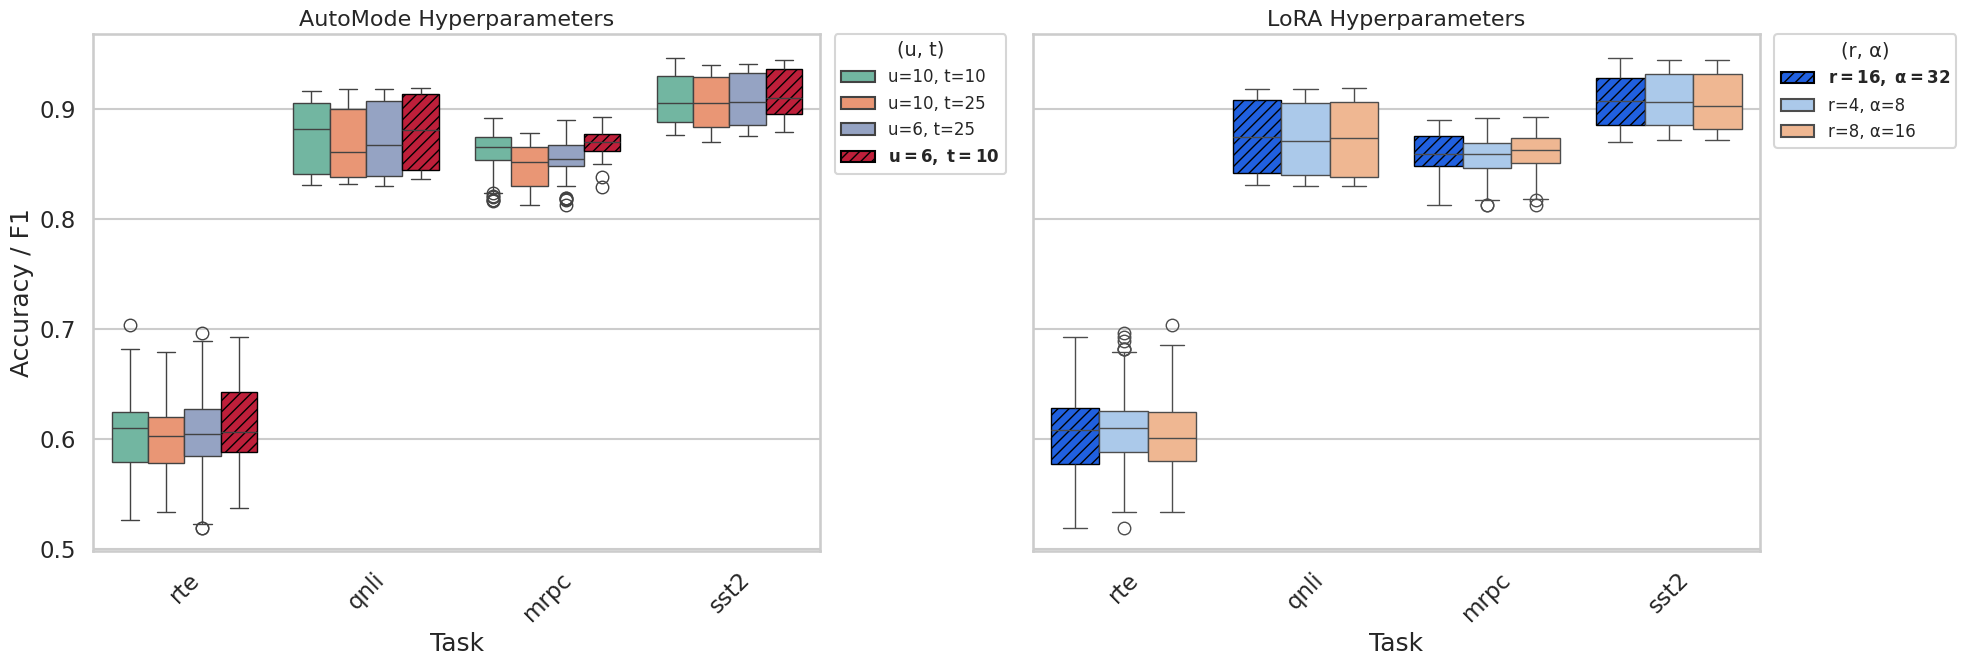

In [21]:

print("\n=== 8. AutoMode and LoRA hyperparameter sensitivity (boxplots) ===")

df_all_metrics = df_final.copy()
df_all_metrics = add_unified_metric_column(df_all_metrics, metric_col="metric")

# AutoMode
df_dyn_hyp = df_all_metrics[df_all_metrics["strategy"] == "dynamic_grad_norm"].copy()
df_dyn_hyp = df_dyn_hyp[df_dyn_hyp["dynamic_config.threshold_percentile"] != 40]
df_dyn_hyp["dyn_group"] = (
    "u=" + df_dyn_hyp["dynamic_config.num_updates_per_epoch"].astype(int).astype(str)
    + ", t=" + df_dyn_hyp["dynamic_config.threshold_percentile"].astype(int).astype(str)
)
best_dyn_label = r"$\mathbf{u=6,\ t=10}$"
df_dyn_hyp["dyn_group"] = df_dyn_hyp["dyn_group"].replace({"u=6, t=10": best_dyn_label})

# LoRA (note: same filter as original, strategy == dynamic_grad_norm)
df_lora_hyp = df_all_metrics[df_all_metrics["strategy"] == "dynamic_grad_norm"].copy()
df_lora_hyp = df_lora_hyp[~df_lora_hyp["lora_config.r"].isna()]
df_lora_hyp["lora_group"] = (
    "r=" + df_lora_hyp["lora_config.r"].astype(int).astype(str)
    + ", α=" + df_lora_hyp["lora_config.lora_alpha"].astype(int).astype(str)
)
best_lora_label = r"$\mathbf{r=16,\ α=32}$"
df_lora_hyp["lora_group"] = df_lora_hyp["lora_group"].replace(
    {"r=16, α=32": best_lora_label}
)

def create_highlight_palette(unique_groups, best_label, vibrant_color):
    """
    Assign vibrant_color to best_label, soft pastel colors to the rest.
    """
    palette = {}
    cur_palette = "pastel" if "r" in best_label else "Set2"
    soft_colors = sns.color_palette(cur_palette, n_colors=len(unique_groups))

    color_idx = 0
    for group in sorted(unique_groups):
        if group == best_label:
            palette[group] = vibrant_color
        else:
            palette[group] = soft_colors[color_idx]
            color_idx += 1
    return palette

dyn_groups = df_dyn_hyp["dyn_group"].unique()
dyn_palette = create_highlight_palette(dyn_groups, best_dyn_label, "#D90429")  # red

lora_groups = df_lora_hyp["lora_group"].unique()
lora_palette = create_highlight_palette(lora_groups, best_lora_label, "#0055FF")  # blue

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)

def apply_hatch(ax, best_label):
    legend = ax.get_legend()
    if not legend:
        return

    best_color_rgba = None
    for handle, text in zip(legend.legend_handles, legend.texts):
        if text.get_text() == best_label:
            best_color_rgba = handle.get_facecolor()
            handle.set_hatch("///")
            handle.set_edgecolor("black")

    if best_color_rgba is not None:
        for patch in ax.patches:
            if mcolors.same_color(patch.get_facecolor(), best_color_rgba):
                patch.set_hatch("///")
                patch.set_edgecolor("black")

# AutoMode boxplot
sns.boxplot(
    ax=axes[0],
    data=df_dyn_hyp,
    x="task",
    y="metric",
    hue="dyn_group",
    palette=dyn_palette,
)
axes[0].set_title("AutoMode Hyperparameters", fontsize=16)
axes[0].set_xlabel("Task")
axes[0].set_ylabel("Accuracy / F1")
axes[0].tick_params(axis="x", rotation=45)
axes[0].legend(
    title="(u, t)",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.0,
    fontsize=12,
    title_fontsize=14,
)
apply_hatch(axes[0], best_dyn_label)

# LoRA boxplot
sns.boxplot(
    ax=axes[1],
    data=df_lora_hyp,
    x="task",
    y="metric",
    hue="lora_group",
    palette=lora_palette,
)
axes[1].set_title("LoRA Hyperparameters", fontsize=16)
axes[1].set_xlabel("Task")
axes[1].set_ylabel("")
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend(
    title="(r, α)",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.0,
    fontsize=12,
    title_fontsize=14,
)
apply_hatch(axes[1], best_lora_label)

plt.tight_layout()
plt.show()



# 8. Layer Activation Timelines (Heatmaps for Selected Runs)

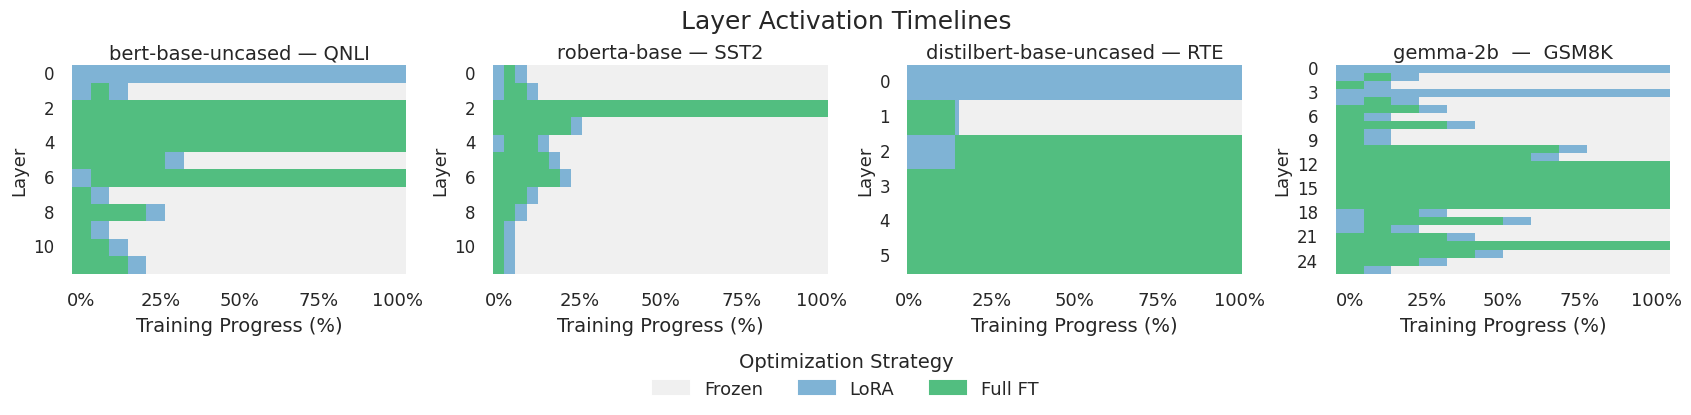

In [ ]:

def parse_layer_index(layer_str):
    """Extract numeric index from e.g. 'base_model.model.model.layers.13'."""
    m = re.search(r"layers\.(\d+)", layer_str)
    return int(m.group(1)) if m else None

def load_gsm8k_layer_logs(log_folder, df_gsm_csv):
    """
    Converts GSM8K JSON logs into df_analysis-style rows.
    Requires the gsm8k CSV file to get exp_id + config info.
    """
    df_gsm = pd.read_csv(df_gsm_csv)
    df_gsm = df_gsm[df_gsm["strategy"] == "dynamic_grad_norm"]

    results = []

    for fname in os.listdir(log_folder):
        if not fname.endswith(".json"):
            continue

        exp_id = fname.split("_")[-1].replace(".json", "")  # matches CSV exp_id
        row = df_gsm[df_gsm["exp_id"] == exp_id]
        if row.empty:
            continue
        row = row.iloc[0]

        t = int(row["dynamic_threshold_percentile"])
        u = int(row["dynamic_num_updates_per_epoch"])

        with open(os.path.join(log_folder, fname), "r") as f:
            data = json.load(f)

        for entry in data:  # each log step
            step = entry["step"]
            layers = entry.get("layers", {})  # each contains {norm, action}
            for lname, info in layers.items():
                layer_id = parse_layer_index(lname)
                if layer_id is None:
                    continue
                results.append({
                    "exp_id": exp_id,
                    "task": "gsm8k",
                    "model": "gemma-2b",
                    "step": step,
                    "layer": f"model.layers.{layer_id}",
                    "layer_id": layer_id,
                    "action": info.get("action", "frozen"),
                    "dynamic_config.threshold_percentile": t,
                    "dynamic_config.num_updates_per_epoch": u,
                })

    return pd.DataFrame(results)


# ======================================================
# STEP 2 — Heatmap Helper Functions
# ======================================================

COLOR_MAP = {0: "#f0f0f0", 1: "#7fb3d5", 2: "#52be80"}
LABELS    = {0: "Frozen", 1: "LoRA", 2: "Full FT"}

def smart_xticks(ax, all_steps):
    """Display x-axis ticks at 0%, 25%, 50%, 75%, 100% of training."""
    n_steps = len(all_steps)
    wanted_percents = list(range(0, 101, 25))
    tick_locs, tick_labels = [], []
    for p in wanted_percents:
        idx = (p / 100) * (n_steps - 1)
        tick_locs.append(idx + 0.5)
        tick_labels.append(f"{p}%")
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(tick_labels, rotation=0, fontsize=13)
    ax.set_xlabel("Training Progress (%)", fontsize=14, labelpad=5)

def plot_one_run(run_id, ax, df_analysis):
    df_run = df_analysis[df_analysis["exp_id"] == run_id].copy()
    df_run = df_run[df_run["layer"] != "all_params"]
    df_run = df_run.sort_values(["step", "layer"])

    if df_run.empty:
        ax.set_title(f"Run {run_id} (NO DATA)", fontsize=12)
        ax.axis("off")
        return

    model = df_run["model"].iloc[0]
    task = df_run["task"].iloc[0]

    df_run["layer_id"] = df_run["layer"].str.extract(r"(\d+)").astype(int)
    df_run["mode"] = df_run["action"].map({"full_ft": 2, "lora_frozen": 1}).fillna(0).astype(int)

    all_layers = sorted(df_run["layer_id"].unique())
    all_steps  = sorted(df_run["step"].unique())

    matrix = pd.DataFrame(0, index=all_layers, columns=all_steps)
    for _, row in df_run.iterrows():
        matrix.at[row["layer_id"], row["step"]] = row["mode"]

    cmap = sns.color_palette([COLOR_MAP[0], COLOR_MAP[1], COLOR_MAP[2]])
    sns.heatmap(matrix, cmap=cmap, vmin=0, vmax=2, cbar=False,
                linewidths=0, linecolor="white", ax=ax)

    if task.lower() == "gsm8k":
        ax.set_title(f"{model}  —  GSM8K", fontsize=14, pad=5)
    else:
        ax.set_title(f"{model} — {task.upper()}", fontsize=14, pad=5)

    ax.set_ylabel("Layer", fontsize=13)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
    smart_xticks(ax, all_steps)
    ax.grid(False)

def plot_multiple_runs(run_ids, df_analysis):
    n = len(run_ids)
    fig, axes = plt.subplots(1, n, figsize=(4.2*n, 3),
                             squeeze=False, constrained_layout=True)

    for idx, run_id in enumerate(run_ids):
        plot_one_run(run_id, axes[0][idx], df_analysis)

    patches = [mpatches.Patch(color=COLOR_MAP[i], label=LABELS[i]) for i in COLOR_MAP]
    fig.legend(handles=patches, loc="lower center",
               bbox_to_anchor=(0.5, -0.25), ncol=3,
               fontsize=13, frameon=False,
               title="Optimization Strategy", title_fontsize=14)

    fig.suptitle("Layer Activation Timelines", fontsize=18, y=1.1)
    plt.show()


# ======================================================
# STEP 3 — EXECUTE 
# ======================================================


# Load GSM8K logs and merge
df_gsm_layers = load_gsm8k_layer_logs(
    log_folder="jsonsnew",
    df_gsm_csv="gsm8k_new_most_recent.csv"
)
df_analysis_new = pd.concat([df_analysis, df_gsm_layers], ignore_index=True)

# GLUE + GSM8K runs
GLUE_RUNS    = ["414491954e", "00a1647f47", "8ce50913fd"]
GSM8K_RUN_ID = "b30675bc30"

plot_multiple_runs(GLUE_RUNS + [GSM8K_RUN_ID], df_analysis_new)


# 9. Layer Importance Across Tasks and Models (GLUE + GSM8K)


=== 10. Layer importance across tasks and models (GLUE + GSM8K) ===


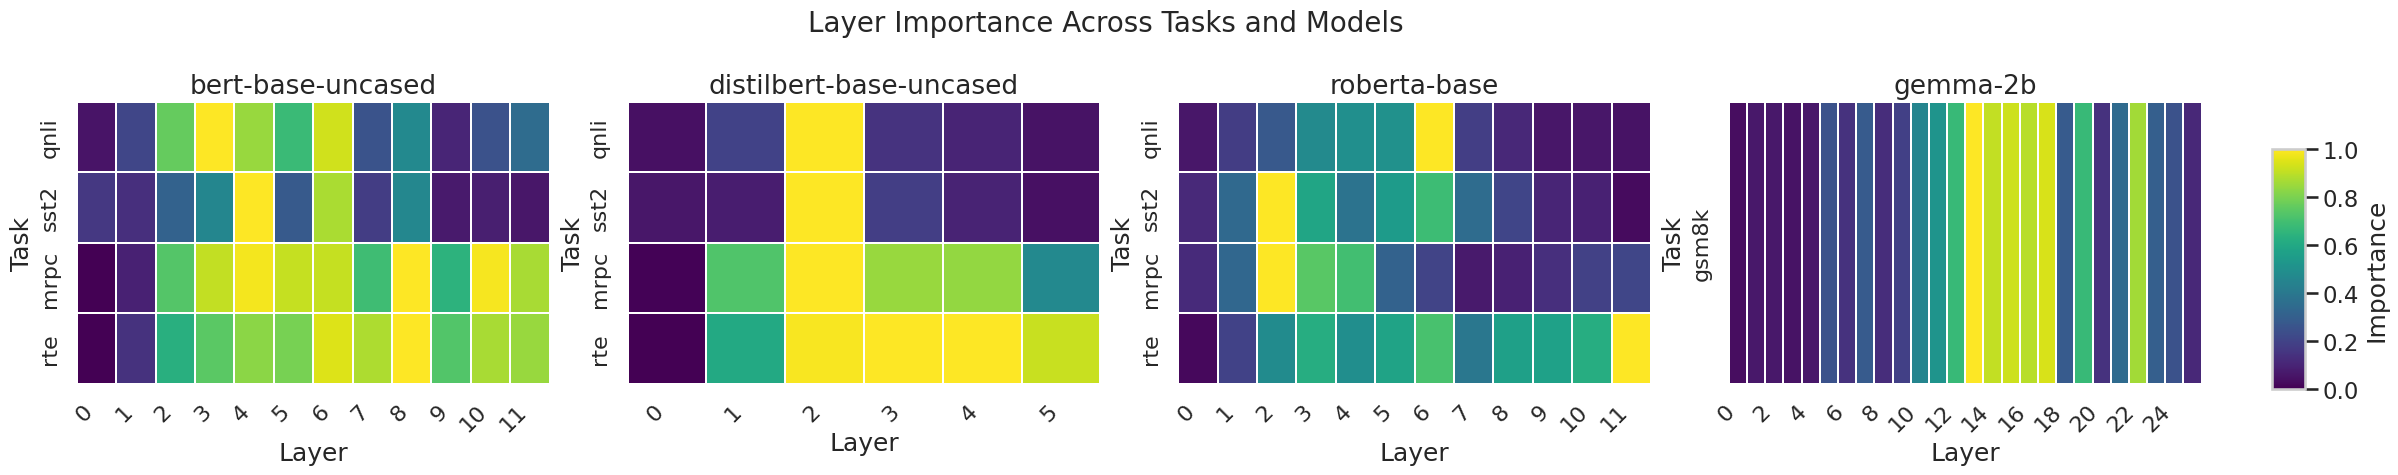

In [30]:

print("\n=== 10. Layer importance across tasks and models (GLUE + GSM8K) ===")

df_imp = df_analysis[df_analysis["action"] == "full_ft"].copy()
df_imp["layer_id"] = df_imp["layer"].str.extract(r"(\d+)").astype(int)
df_glue = df_imp[["task", "model", "layer_id"]].copy()

csv_path_gsm2 = "gsm8k_new_most_recent.csv"
df_gsm2 = pd.read_csv(csv_path_gsm2)
df_gsm2 = df_gsm2[df_gsm2["strategy"] == "dynamic_grad_norm"].copy()

records = []
logs_folder2 = "jsonsnew"

for fname in os.listdir(logs_folder2):
    if not fname.endswith(".json"):
        continue

    run_id = fname.split("_")[-1].replace(".json", "")
    row = df_gsm2[df_gsm2["exp_id"] == run_id]
    if len(row) == 0:
        continue
    row = row.iloc[0]

    with open(os.path.join(logs_folder2, fname), "r") as f:
        log_data = json.load(f)

    for entry in log_data:
        if "layers" not in entry:
            continue
        for layer_name, state in entry["layers"].items():
            layer_id = int(layer_name.split(".")[-1])
            if state["action"] == "full_ft":
                records.append(
                    {
                        "task": "gsm8k",
                        "model": "gemma-2b",
                        "layer_id": layer_id,
                    }
                )

df_gsm_layers = pd.DataFrame(records)

df_all_layers = pd.concat([df_glue, df_gsm_layers], ignore_index=True)

df_counts = (
    df_all_layers.groupby(["task", "model", "layer_id"])
    .size()
    .reset_index(name="count")
)

df_counts["norm"] = df_counts.groupby(["task", "model"])["count"].transform(
    lambda x: x / x.max() if x.max() > 0 else x
)

models_order = ["bert-base-uncased", "distilbert-base-uncased", "roberta-base", "gemma-2b"]
task_order2 = ["qnli", "sst2", "mrpc", "rte", "gsm8k"]

fig, axes = plt.subplots(1, len(models_order), figsize=(22, 4), constrained_layout=True)
cmap = sns.color_palette("viridis", as_cmap=True)

for ax, model in zip(axes, models_order):
    df_m = df_counts[df_counts["model"] == model]

    pivot = df_m.pivot_table(
        index="task",
        columns="layer_id",
        values="norm",
        fill_value=0,
    )

    pivot = pivot.reindex(task_order2).dropna(how="all")
    pivot = pivot.reindex(sorted(pivot.columns), axis=1)

    sns.heatmap(
        pivot,
        cmap=cmap,
        vmin=0,
        vmax=1,
        ax=ax,
        cbar=False,
        linewidths=0.15,
    )

    ax.set_title(model, fontsize=19)
    ax.set_xlabel("Layer")
    ax.set_ylabel("Task")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)

cbar_ax = fig.add_axes([1.03, 0.2, 0.015, 0.6])
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, label="Importance")
fig.suptitle("Layer Importance Across Tasks and Models", fontsize=20, y=1.15)

plt.show()


# 10. LoRA Hyperparameters: Best per Task

In [24]:

print("\n=== 11. Best LoRA hyperparameters per task ===")

df_lora_summary = df_final[df_final["strategy"] == "lora"].copy()
df_lora_summary = add_unified_metric_column(df_lora_summary, metric_col="metric")

group_cols = ["task", "lr", "lora_config.r", "lora_config.lora_alpha"]
df_grouped = (
    df_lora_summary.groupby(group_cols)["metric"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

df_grouped["mean_std"] = df_grouped.apply(
    lambda r: f"{r['mean']:.4f} ± {r['std']:.4f}", axis=1
)

best_per_task = df_grouped.loc[df_grouped.groupby("task")["mean"].idxmax()].sort_values("task")

print(best_per_task)




=== 11. Best LoRA hyperparameters per task ===
    task       lr  lora_config.r  lora_config.lora_alpha      mean       std  \
5   mrpc  0.00003           16.0                    32.0  0.831873  0.023184   
11  qnli  0.00003           16.0                    32.0  0.858035  0.027841   
17   rte  0.00003           16.0                    32.0  0.557561  0.038296   
23  sst2  0.00003           16.0                    32.0  0.906473  0.018590   

    count         mean_std  
5       9  0.8319 ± 0.0232  
11      9  0.8580 ± 0.0278  
17      9  0.5576 ± 0.0383  
23      9  0.9065 ± 0.0186  


# 11. Best Full Fine-Tuning Learning Rates per Task

In [25]:

print("\n=== 12. Best Full Fine-Tuning learning rates per task ===")

df_ft = df_final[df_final["strategy"] == "full_ft"].copy()
df_ft = add_unified_metric_column(df_ft, metric_col="metric")

print(f"- Number of full_ft runs: {len(df_ft)}")

grouped_ft = (
    df_ft.groupby(["task", "lr"])["metric"]
    .agg(["mean", "std"])
    .reset_index()
)

best_rows = []
for task, sub in grouped_ft.groupby(["task"]):
    best = sub.loc[sub["mean"].idxmax()]
    best_rows.append(best)

df_best_ft = pd.DataFrame(best_rows)
df_best_ft["mean_std"] = df_best_ft.apply(
    lambda r: f"{r['mean']:.4f} ± {r['std']:.4f}", axis=1
)
df_best_ft = df_best_ft.sort_values(["task"]).reset_index(drop=True)

print(df_best_ft[["task", "lr", "mean_std"]])



=== 12. Best Full Fine-Tuning learning rates per task ===
- Number of full_ft runs: 72
   task       lr         mean_std
0  mrpc  0.00002  0.9020 ± 0.0143
1  qnli  0.00002  0.9101 ± 0.0161
2   rte  0.00002  0.6582 ± 0.0763
3  sst2  0.00003  0.9248 ± 0.0166


# 12. Main Restults: Strategy Comparison per Model/Task

In [26]:

print("\n=== 13. Strategy comparison table (per model × task) ===")

df_summary = df_final.copy()
df_summary = add_unified_metric_column(df_summary, metric_col="metric")

# Strategy-specific filters (unchanged logic)
df_fullft_fixed = df_summary[
    (df_summary["strategy"] == "full_ft") &
    np.isclose(df_summary["lr"], 0.00002)
]

df_lora_fixed = df_summary[
    (df_summary["strategy"] == "lora") &
    (df_summary["lr"] == 0.00003) &
    (df_summary["lora_config.r"] == 16) &
    (df_summary["lora_config.lora_alpha"] == 32)
]

df_bitfit = df_summary[df_summary["strategy"] == "bitfit"]

df_topk_k5 = df_summary[
    (df_summary["strategy"] == "topk_full") &
    (df_summary["topk_layers.k"] == 5)
]

df_dyn_fixed = df_summary[
    (df_summary["strategy"] == "dynamic_grad_norm") &
    (df_summary["dynamic_config.num_updates_per_epoch"] == 6) &
    (df_summary["dynamic_config.threshold_percentile"] == 10) &
    (df_summary["lora_config.r"] == 16) &
    (df_summary["lora_config.lora_alpha"] == 32)
]

def summarize(df_subset):
    out = {}
    for task in ["mrpc", "qnli", "rte", "sst2"]:
        sub = df_subset[df_subset["task"] == task]
        if len(sub) == 0:
            out[task] = "-"
            continue
        m = sub["metric"].mean()
        s = sub["metric"].std()
        t = sub["training_time_seconds"].mean()
        out[task] = f"{m:.4f} ± {s:.4f} ({t:.1f}s)"
    return out

rows = []
for model in df_summary["model"].unique():
    rows.append(
        {
            "model": model,
            "strategy": "Full-FT",
            **summarize(df_fullft_fixed[df_fullft_fixed["model"] == model]),
        }
    )
    rows.append(
        {
            "model": model,
            "strategy": "LoRA (best)",
            **summarize(df_lora_fixed[df_lora_fixed["model"] == model]),
        }
    )
    rows.append(
        {
            "model": model,
            "strategy": "BitFit",
            **summarize(df_bitfit[df_bitfit["model"] == model]),
        }
    )
    rows.append(
        {
            "model": model,
            "strategy": "Top-k (k=5)",
            **summarize(df_topk_k5[df_topk_k5["model"] == model]),
        }
    )
    rows.append(
        {
            "model": model,
            "strategy": "AutoMode (u=6, t=10)",
            **summarize(df_dyn_fixed[df_dyn_fixed["model"] == model]),
        }
    )

final_table = pd.DataFrame(rows)
print(final_table)



=== 13. Strategy comparison table (per model × task) ===
                      model              strategy                      mrpc  \
0   distilbert-base-uncased               Full-FT  0.8921 ± 0.0027 (282.8s)   
1   distilbert-base-uncased           LoRA (best)  0.8210 ± 0.0005 (207.2s)   
2   distilbert-base-uncased                BitFit     0.8122 ± nan (197.5s)   
3   distilbert-base-uncased           Top-k (k=5)     0.9012 ± nan (242.4s)   
4   distilbert-base-uncased  AutoMode (u=6, t=10)  0.8785 ± 0.0067 (186.2s)   
5         bert-base-uncased               Full-FT  0.8945 ± 0.0099 (541.1s)   
6         bert-base-uncased           LoRA (best)  0.8128 ± 0.0071 (394.3s)   
7         bert-base-uncased                BitFit     0.8122 ± nan (381.3s)   
8         bert-base-uncased           Top-k (k=5)     0.8548 ± nan (335.4s)   
9         bert-base-uncased  AutoMode (u=6, t=10)  0.8641 ± 0.0110 (384.1s)   
10             roberta-base               Full-FT  0.9195 ± 0.0049 (545.1

# 13. AutoMode vs LoRA vs Full-FT: Accuracy & Speed Improvements

In [27]:

print("\n=== 14. AutoMode vs LoRA vs Full-FT: improvements summary ===")

df_cmp = df_final.copy()
df_cmp = add_unified_metric_column(df_cmp, metric_col="metric")

# Filters (same as original)
df_lora_cmp = df_cmp[
    (df_cmp["strategy"] == "lora") &
    (df_cmp["lr"] == 0.00003) &
    (df_cmp["lora_config.r"] == 16) &
    (df_cmp["lora_config.lora_alpha"] == 32)
]

df_auto_cmp = df_cmp[
    (df_cmp["strategy"] == "dynamic_grad_norm") &
    (df_cmp["dynamic_config.num_updates_per_epoch"] == 6) &
    (df_cmp["dynamic_config.threshold_percentile"] == 10) &
    (df_cmp["lora_config.r"] == 16) &
    (df_cmp["lora_config.lora_alpha"] == 32)
]

best_lr_fullft = {
    "mrpc": 0.00002,
    "qnli": 0.00002,
    "rte":  0.00002,
    "sst2": 0.00003,
}

df_fullft_cmp = df_cmp[
    (df_cmp["strategy"] == "full_ft") &
    (df_cmp.apply(lambda r: r["lr"] == best_lr_fullft[r["task"]], axis=1))
]

# Aggregate stats across strategies (unchanged logic)
agg = df_cmp.groupby(["strategy", "model", "task"]).agg(
    mean_metric=("metric", "mean"),
    mean_time=("training_time_seconds", "mean")
).reset_index()

auto_stats = agg[agg["strategy"] == "dynamic_grad_norm"]
lora_stats = agg[agg["strategy"] == "lora"]
ft_stats   = agg[agg["strategy"] == "full_ft"]

merged = auto_stats.merge(
    lora_stats, on=["model", "task"], suffixes=("_auto", "_lora")
).merge(
    ft_stats, on=["model", "task"]
)

merged = merged.rename(columns={
    "mean_metric": "mean_metric_ft",
    "mean_time":   "mean_time_ft"
})

# Accuracy % differences
merged["acc_improve_auto_vs_lora_%"] = 100 * (merged["mean_metric_auto"] - merged["mean_metric_lora"]) / merged["mean_metric_lora"]
merged["acc_improve_auto_vs_ft_%"]   = 100 * (merged["mean_metric_auto"] - merged["mean_metric_ft"])   / merged["mean_metric_ft"]
merged["acc_improve_lora_vs_ft_%"]   = 100 * (merged["mean_metric_lora"] - merged["mean_metric_ft"])   / merged["mean_metric_ft"]

# Training time % speedup (positive = faster)
merged["speedup_auto_vs_lora_%"] = 100 * (merged["mean_time_lora"] - merged["mean_time_auto"]) / merged["mean_time_lora"]
merged["speedup_auto_vs_ft_%"]   = 100 * (merged["mean_time_ft"]   - merged["mean_time_auto"]) / merged["mean_time_ft"]
merged["speedup_lora_vs_ft_%"]   = 100 * (merged["mean_time_ft"]   - merged["mean_time_lora"]) / merged["mean_time_ft"]

# Clean rounding
merged = merged.round({
    "acc_improve_auto_vs_lora_%": 1,
    "acc_improve_auto_vs_ft_%": 1,
    "acc_improve_lora_vs_ft_%": 1,
    "speedup_auto_vs_lora_%": 1,
    "speedup_auto_vs_ft_%": 1,
    "speedup_lora_vs_ft_%": 1
})

final_cmp = merged[[
    "model", "task",

    # AutoMode performance
    "mean_metric_auto", "mean_time_auto",

    # LoRA performance
    "mean_metric_lora", "mean_time_lora",

    # Full FT performance
    "mean_metric_ft",   "mean_time_ft",

    # Improvements
    "acc_improve_auto_vs_lora_%",
    "speedup_auto_vs_lora_%",

    "acc_improve_auto_vs_ft_%",
    "speedup_auto_vs_ft_%"
]]

print("mean of acc_improve_auto_vs_lora_%:", final_cmp["acc_improve_auto_vs_lora_%"].mean())
print("mean of speedup_auto_vs_lora_%:",    final_cmp["speedup_auto_vs_lora_%"].mean())
print("mean of acc_improve_auto_vs_ft_%:",  final_cmp["acc_improve_auto_vs_ft_%"].mean())
print("mean of speedup_auto_vs_ft_%:",      final_cmp["speedup_auto_vs_ft_%"].mean())



=== 14. AutoMode vs LoRA vs Full-FT: improvements summary ===
mean of acc_improve_auto_vs_lora_%: 5.191666666666667
mean of speedup_auto_vs_lora_%: 12.166666666666666
mean of acc_improve_auto_vs_ft_%: -4.250000000000001
mean of speedup_auto_vs_ft_%: 39.108333333333334
